In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

![jupyter](https://nchlis.github.io/2019_10_30/architecture_unetV2.png)

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

2022-10-30 03:28:45.928829: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `keras` framework.


[0 6]


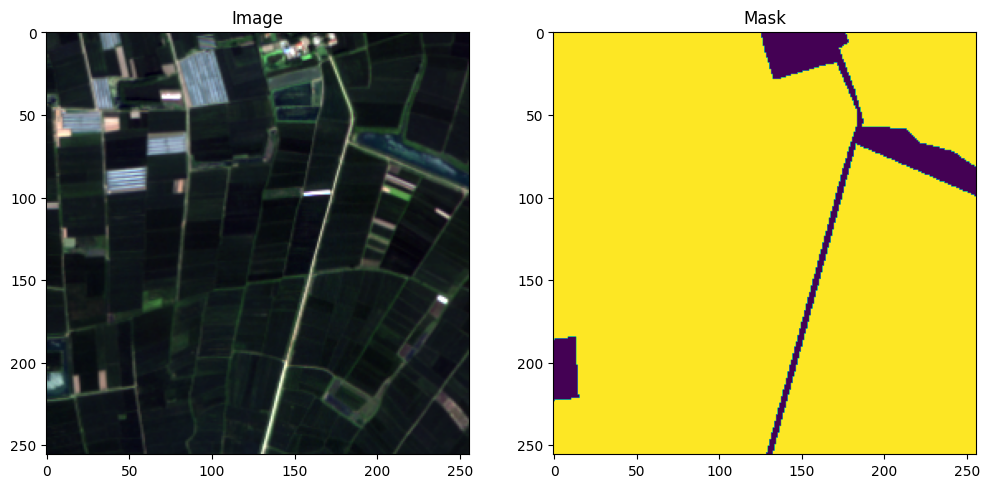

In [3]:
train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='viridis')
print(np.unique(mask_for_plot))
plt.title('Mask')
plt.show()

In [4]:
seed=42
batch_size= 16
n_classes=16

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Label information of 15 classes:

* background - 0

* industrial land - 1
* urban residential - 2
* rural residential - 3
* traffic land - 4

* paddy field - 5
* irrigated land - 6
* dry cropland - 7
* garden plot - 8

* arbor woodland - 9
* shrub land - 10

* natural grassland - 11
* artificial grassland - 12

* river - 13
* lake - 14
* pond - 15

In [5]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    mask = to_categorical(mask, num_class)
    return (img, mask)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class, aug=True):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    if aug:
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [7]:
train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

Found 35292 images belonging to 1 classes.
Found 35292 images belonging to 1 classes.


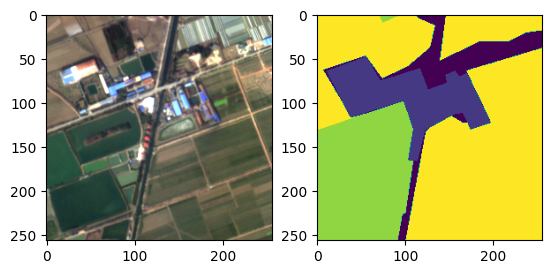

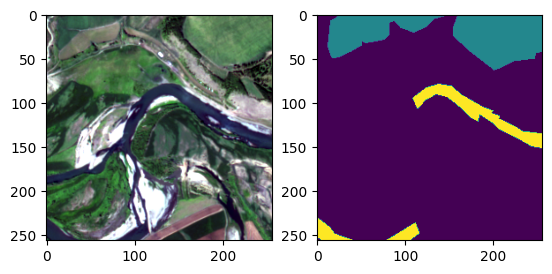

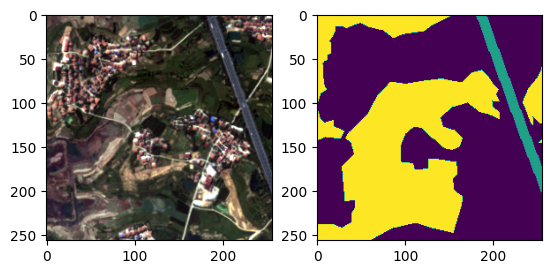

Found 6920 images belonging to 1 classes.
Found 6920 images belonging to 1 classes.
[ 0  4  6 15]


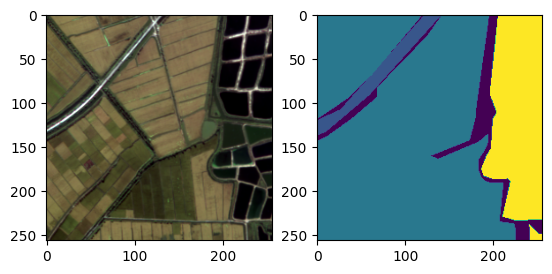

[0 7]


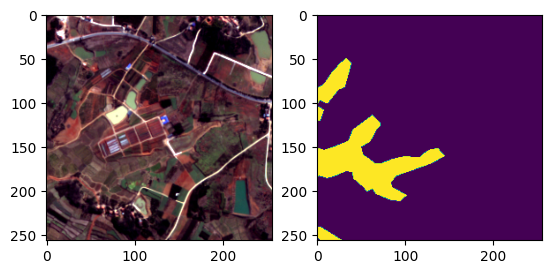

[ 0  1  6 10]


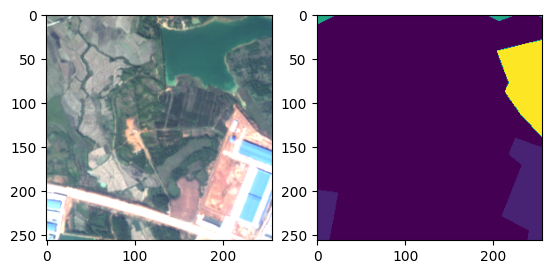

In [8]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    print(np.unique(mask))
    plt.show()

In [9]:
num_train_imgs = len(os.listdir(train_img_path+"/train"))
num_val_images = len(os.listdir(val_img_path+"/val"))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = 3

In [10]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

 D)                                                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_6[0][0]']       
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_13[0][0]']      
                                                                                                  
 add_5 (Add)                    (None, 32, 32, 128)  0           ['stage2_unit3_conv2[0][0]',     
          

                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_19[0][0]']      
                                                                                                  
 add_8 (Add)                    (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_8[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit3_bn1[0][0]']       
 )        

                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_26 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_26[0][0]']      
                                                                                                  
 stage3_unit6_bn2 (BatchNormali  (None, 16, 16, 256)  1024       ['stage3_unit6_conv1[0][0]']     
 zation)  

                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_32[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_33 (ZeroPadding  (None, 10, 10, 512)  0          ['stage4_unit3_relu2[0][0]']     
 2D)      

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_s

In [11]:
model.load_weights('unet_weights.h5')

In [128]:
history=model.fit(train_img_gen,
              steps_per_epoch=steps_per_epoch,
              epochs=25,
              verbose=1,
              validation_data=val_img_gen,
              validation_steps=val_steps_per_epoch)

Epoch 1/25
  16/2205 [..............................] - ETA: 6:23 - loss: 0.6149 - iou_score: 0.4266

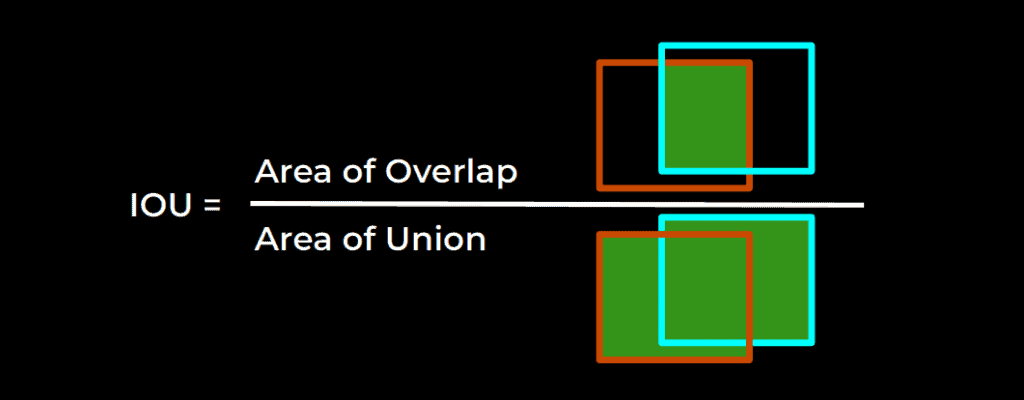

In [136]:
# model.save_weights('unet_weights.h5')

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
    
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

img_num = random.randint(0, test_image_batch.shape[0]-1)

print(np.unique(test_mask_batch_argmax[img_num]))
print(np.unique(test_pred_batch_argmax[img_num]))

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [ ]:
confusion_matrix = np.zeros((16, 16))
matrix = confusion_matrix
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes, aug=False)

In [28]:
from sklearn.metrics import confusion_matrix
from collections import Counter
from tensorflow.experimental.numpy import ravel
from tensorflow import stack, cast, int32, make_ndarray
import tqdm
import pandas as pd
import cudf


for _ in tqdm.tqdm(range(val_steps_per_epoch)):
    image_batch, mask_batch = val_img_gen.__next__()

    x = model.predict(image_batch, verbose=0)

    y_true_batch = ravel(mask_batch.argmax(axis=3))
    y_pred_batch = ravel(x.argmax(axis=3))
    y_pairs = stack((y_true_batch, y_pred_batch), axis=-1)
    
    y_pairs = cudf.DataFrame(y_pairs.numpy(), columns=['true', 'pred'])
    y_pairs['count'] = 1

    grouped = y_pairs.groupby(by=['true', 'pred'],as_index=False).sum()
    grouped = grouped.to_numpy()

    for true, pred, count in grouped:
        matrix[int(true)][int(pred)] += np.round(count / (256*256*16), 2)

100%|█████████████████████████████████████████| 432/432 [06:08<00:00,  1.17it/s]


<AxesSubplot: >

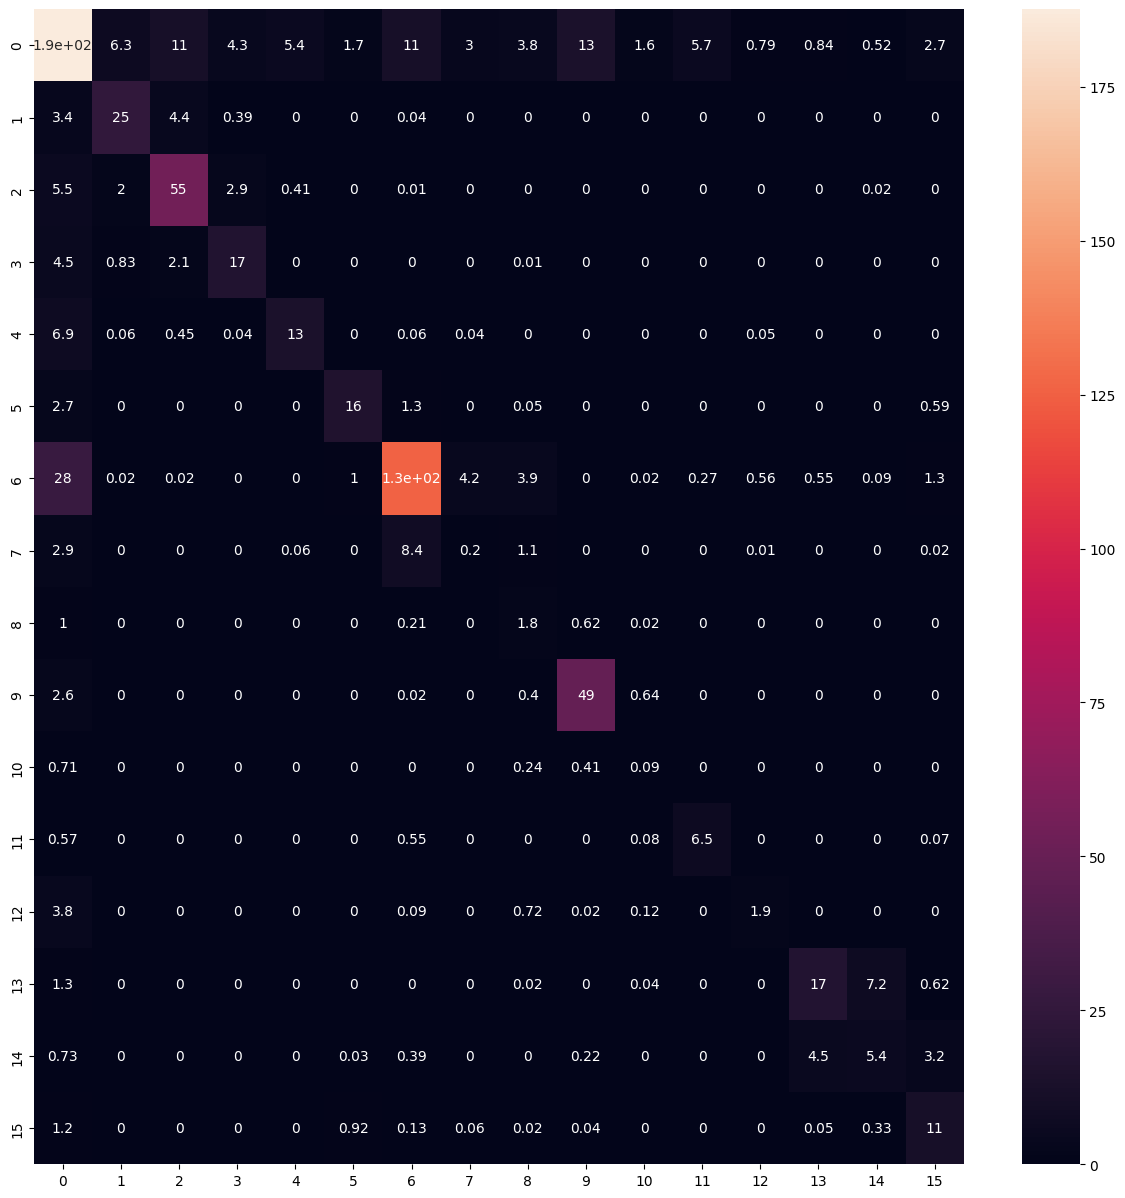

In [30]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(matrix, annot=True)

## Label information of 15 classes:

* background - 0

* industrial land - 1
* urban residential - 2
* rural residential - 3
* traffic land - 4

* paddy field - 5
* irrigated land - 6
* dry cropland - 7
* garden plot - 8

* arbor woodland - 9
* shrub land - 10

* natural grassland - 11
* artificial grassland - 12

* river - 13
* lake - 14
* pond - 15

## Confusion matrix

## Планы
- 1) построить confusion matrix
- 2) объединить классы на основании cm
- 3) другие backbone
- 4) финальная модель